In [115]:
%pylab inline
import biff
from scipy import special
import pygadgetreader
import reading_snapshots
import gadget_read_snap 

Populating the interactive namespace from numpy and matplotlib


In [132]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)


In [16]:
r_s_sims = 40.85
G_gadget=43007.1 #kpc3/(Gyr2Msun)/1E10. 

In [14]:
def acceleration_spherical(pos, acc):
    r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)

    theta = np.arccos(pos[:,2]/r) 
    phi = np.arctan2(pos[:,1], pos[:,0])

    a_r = np.sin(theta)*np.cos(phi)*acc[:,0] + \
         np.sin(theta)*np.sin(phi)*acc[:,1] + \
         np.cos(theta)*acc[:,2] 

    a_theta = np.cos(theta)*np.cos(phi)*acc[:,0] +\
              np.cos(theta)*np.sin(phi)*acc[:,1] - \
              np.sin(theta)*acc[:,2]

    a_phi = -np.sin(phi)*acc[:,0] + np.cos(phi)*acc[:,1]

    return a_r, a_theta, a_phi

In [17]:
def Anl(n, l):
    knl = 0.5*n*(n+4*l+3) + (l+1)*(2*l+1)
    A_nl = - 2**(8*l+6)/(4*np.pi*knl) * (special.factorial(n)*(n+2*l+3/2.)*(special.gamma(2*l+3/2.))**2)/(special.gamma(n+4*l+3))
    return A_nl

In [18]:
def copy_matrix(M, indices):
    M_new = np.zeros(shape(M))
    for i in range(len(indices[0])):
        M_new[indices[0][i]][indices[1][i]][indices[2][i]] = M[indices[0][i]][indices[1][i]][indices[2][i]]
    return M_new
    
def coefficients_energy_level(S, T, e_cut, verb=0):
    """
    Returns coefficients with energy higher than e_cut
    e_cut : float 
        between 0 and 1
        
    """
    n_max = shape(S)[0]
    l_max = shape(S)[1]
    m_max = shape(S)[2]
    
    
    A_nl_array = np.zeros((n_max, l_max))
    for j in range(n_max):
        for i in range(l_max):
            A_nl_array[j][i] = Anl(j, i)
    A_nl_matrix = np.zeros((n_max, l_max, m_max))
    for i in range(m_max):
        A_nl_matrix[:,:,i] = A_nl_array
    
    U_nlm = 0.5*(S**2 + T**2)/A_nl_matrix
    U_all = np.sum(U_nlm)
    energy_cut = np.where(np.log10(np.abs(U_nlm))>np.log10(np.abs(U_all))*e_cut)
    if verb == 1:
        print('\sum U = ',np.log10(np.abs(U_all)))
        print('U cut = ',np.log10(np.abs(U_all))*e_cut)
        print('N coeff = ', len(energy_cut[0]))

    S_new = copy_matrix(S, energy_cut)
    T_new = copy_matrix(T, energy_cut)
    return S_new, T_new, [np.max(energy_cut[0]) ,np.max(energy_cut[1]), np.max(energy_cut[2])]
    
    

In [19]:
n_max = l_max = m_max = 21
A_nl_array = np.zeros((n_max, l_max))
for j in range(n_max):
    for i in range(l_max):
        A_nl_array[j][i] = Anl(j, i)
A_nl_matrix = np.zeros((n_max, l_max, m_max))
for i in range(m_max):
    A_nl_matrix[:,:,i] = A_nl_array

In [29]:
## Application to the LMC + MW 

In [20]:
r_s_sims = 40.85

In [11]:
MW_mass = pygadgetreader.readsnap('../../MW_anisotropy/code/test_snaps/MWLMC5_100M_new_b1_110', 'mass', 'dm')

Returning DM    Mass


In [12]:
MW_mass[0]

1.5772125e-06

In [26]:
pos_dm_halo = pygadgetreader.readsnap('./MWLMC/MWLMC5_100M_b1_dmhalopart_1e6_000',  'pos', 'dm')

Returning DM    Positions


In [22]:
pot_dm_halo = pygadgetreader.readsnap('./MWLMC/MWLMC5_100M_b1_dmhalopart_1e6_000',  'pot', 'dm')

Returning DM    Potential


In [24]:
#S_mwlmc1_6, T_mwlmc_1e7 = biff.compute_coeffs_discrete(np.double(pos_dm_halo), np.ones(len(pos_dm_halo))*(MW_mass[0]*100), 20, 20, 20, compute_var=False)

In [58]:
a_mwlmc_biff_1e6 = biff.gradient(pos_mwlmc5_b1_1e6[N_rand1], S_mwlmc1_6, T_mwlmc_1e7, G=G_gadget, M=1, r_s=r_s_sims)


In [35]:
## gadget 

accel_mwlmc5_b1_1e6 = genfromtxt('acclerations_mwlmc5_b1_1e6.txt')
pos_mwlmc5_b1_1e6 = genfromtxt('pos_mwlmc5_b1_1e6.txt')

In [117]:
pos_mwlmc5_b1_1e8, pot_mwlmc5_b1_1e8, acc_mwlmc5_b1_1e8 = gadget_read_snap.read_snap('MW/gadget3_MWLMC5_100M_b1_dmhalopart_elgato_1e8_001')

256
1200000000 blocksize pp
400000000 blocksize ids
400000000 blocksize mass


In [90]:
S_mwlmc1_6, T_mwlmc_1e6 = biff.compute_coeffs_discrete(np.double(pos_mwlmc5_b1_1e6), np.ones(len(pos_dm_halo))*MW_mass[0], 20, 20,
                                                       r_s=r_s_sims, compute_var=False)

In [118]:
coeff_c8 = np.loadtxt('../../SCF_tools/PCA/MWLMC5_coeff_20_20_100M_b1.txt')
S_mw_1e8 = coeff_c8[:,0]
T_mw_1e8 = coeff_c8[:,1]

S_matrix_mw_1e8 = np.zeros((21, 21, 21))
T_matrix_mw_1e8 = np.zeros((21, 21, 21))


counter = 0
for n in range(21):
    for l in range(21):
        for m in range(0, l+1):
            S_matrix_mw_1e8[n][l][m] = S_mw_1e8[counter]
            T_matrix_mw_1e8[n][l][m] = T_mw_1e8[counter]
            counter +=1

In [91]:
r_mwlmc5_b1_1e6 = (pos_mwlmc5_b1_1e6[:,0]**2 + pos_mwlmc5_b1_1e6[:,1]**2 + pos_mwlmc5_b1_1e6[:,2]**2)**0.5

In [119]:
r_mwlmc5_b1_1e8 = (pos_mwlmc5_b1_1e8[:,0]**2 + pos_mwlmc5_b1_1e8[:,1]**2 + pos_mwlmc5_b1_1e8[:,2]**2)**0.5

In [92]:
#a_r, a_t, a_p = acceleration_spherical(pos_mwlmc5_b1_1e6, accel_mwlmc5_b1_1e6)

In [102]:
N_rand1 = np.random.randint(0, len(pos_mwlmc5_b1_1e6), 5000)

In [120]:
N_rand2 = np.random.randint(0, len(pos_mwlmc5_b1_1e8), 5000)

In [103]:
a_mwlmc_biff_1e6 = biff.gradient(pos_mwlmc5_b1_1e6[N_rand1], S_mwlmc1_6, T_mwlmc_1e6, G=G_gadget, M=1, r_s=r_s_sims)

In [129]:
a_mwlmc_biff_1e8 = MW_mass[0]*biff.gradient(np.double(pos_mwlmc5_b1_1e8[N_rand2]), S_matrix_mw_1e8, T_matrix_mw_1e8, G=G_gadget, M=1, r_s=r_s_sims)

In [88]:
MW_mass[0]

1.5772125e-06

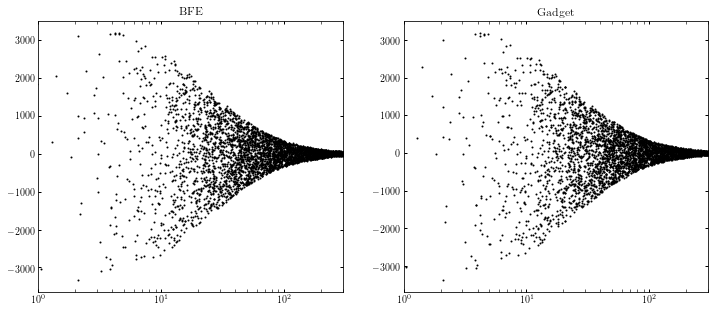

In [130]:
figure(figsize=(12, 5))
subplot(1, 2, 1)
title('BFE')
scatter(r_mwlmc5_b1_1e8[N_rand2], a_mwlmc_biff_1e8[:,0], s=1, c='k')
xlim(1, 300)
xscale('log')

subplot(1, 2, 2)
title('Gadget')
scatter(r_mwlmc5_b1_1e8[N_rand2], -acc_mwlmc5_b1_1e8[:,0][N_rand2], s=1, c='k')
xlim(1, 300)
xscale('log')
#yscale('log')

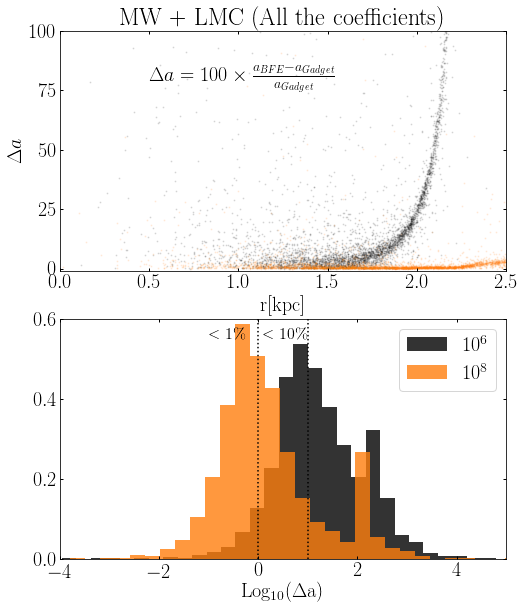

In [217]:
r_sort = argsort(r_mwlmc5_b1_1e6[N_rand1])
r_sort2 = argsort(r_mwlmc5_b1_1e8[N_rand2])

figure(figsize=(8, 15))

subplot(3, 1, 1)
title('MW + LMC (All the coefficients)')

scatter(np.log10(r_mwlmc5_b1_1e6[N_rand1][r_sort]), 100*np.abs(-a_mwlmc_biff_1e6[r_sort,0]-accel_mwlmc5_b1_1e6[N_rand1,0][r_sort])/np.abs(accel_mwlmc5_b1_1e6[N_rand1,0][r_sort]), 
         c='k', alpha=0.1, s=1)

scatter(np.log10(r_mwlmc5_b1_1e8[N_rand2][r_sort2]), 100*np.abs(-a_mwlmc_biff_1e8[r_sort2,0]-acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2])/np.abs(acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2]), 
         c='C1', alpha=0.1, s=1)


#scatter(np.log10(r_sims_1e7[N_rand_1e7][r_sort2]), 100*np.abs(-a_mwlmc_biff_1e7[r_sort2,0]-acc_gadget_1e7[N_rand_1e7,0][r_sort2])/np.abs(acc_gadget_1e7[N_rand_1e7,0][r_sort2]), 
#         c='C0', alpha=0.1, s=1)

xlim(0, 2.5)
ylim(-1, 100)

ylabel('$\Delta a$')
xlabel('r[kpc]')

text(0.5, 75, r'$\Delta a = 100 \times \frac{a_{BFE} - a_{Gadget}}{a_{Gadget}}$')



subplot(3, 1, 2)
h = hist(np.log10(100*np.abs(-a_mwlmc_biff_1e6[r_sort,0]-accel_mwlmc5_b1_1e6[N_rand1,0][r_sort])/np.abs(accel_mwlmc5_b1_1e6[N_rand1,0][r_sort]))
        , bins=30, color='k', alpha=0.8, label='$10^{6}$', normed=True)


h = hist(np.log10(100*np.abs(-a_mwlmc_biff_1e8[r_sort2,0]-acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2])/np.abs(acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2]))
        , bins=30, color='C1', alpha=0.8, label='$10^{8}$', normed=True)

#h = hist(np.log10(100*np.abs(-a_mwlmc_biff_1e7[r_sort2,0]-acc_gadget_1e7[N_rand_1e7,0][r_sort2])/np.abs(acc_gadget_1e7[N_rand_1e7,0][r_sort2]))
#        , bins=30, alpha=0.5, label='$10^{7}$', normed=True)

legend()
axvline(np.log10(1), c='k', ls=':')
axvline(np.log10(10), c='k', ls=':')
xlim(-4, 5)
text(-1, 0.55, r'$<1\%$', fontsize=16)
text(0.1, 0.55, r'$<10\%$', fontsize=16)
ylim(0, 0.6)
xlabel(r'$\rm{Log_{10}}(\Delta a)$')

#subplot(3, 1, 3)
#
#text(-3.9, 0.8, '$n=0, l=0, m=0$')
#h = hist(np.log10(100*np.abs(-a_mwlmc_biff_1e6_000[r_sort,0]-acc_gadget_1e6[N_rand_1e6,0][r_sort])/np.abs(acc_gadget_1e6[N_rand_1e6,0][r_sort]))
#        , bins=30, alpha=0.8, label='$10^{7}$', normed=True, color='k')

#h = hist(np.log10(100*np.abs(-a_mwlmc_biff_1e7_000[r_sort2,0]-acc_gadget_1e7[N_rand_1e7,0][r_sort2])/np.abs(acc_gadget_1e7[N_rand_1e7,0][r_sort2]))
#        , bins=30, alpha=0.5, label='$10^{7}$', normed=True)



#axvline(np.log10(1), c='k', ls=':')
#axvline(np.log10(10), c='k', ls=':')
#xlim(-4, 5)

#text(-1, 0.7, r'$<1\%$', fontsize=16)
#text(0.1, 0.7, r'$<10\%$', fontsize=16)

#xlabel(r'$\rm{Log_{10}}(\Delta a)$')
savefig('mwlmc_acc.png', bbox_inches='tight')
savefig('mwlmc_acc.pdf', bbox_inches='tight')

In [215]:
#figure(figsize=(10, 6))

e_cuts = [0.4, 0.5, 0.6, 0.7]
coeff_order = np.zeros((len(e_cuts),3))
j=0

N_coeff = [558, 173, 57, 11]
for i in e_cuts:

    S, T, coeff_order[j] = coefficients_energy_level(S_matrix_mw_1e8, T_matrix_mw_1e8, i, verb=1)
    a_e = MW_mass[0]*biff.gradient(np.double(pos_mwlmc5_b1_1e8[N_rand2]), S, T, G=G_gadget, M=1, r_s=r_s_sims)

    figsize=(10, 6)
    title('Ncoeff = {}'.format(str(N_coeff[j])))
    
    h1 = hist(np.log10(100*np.abs(-a_mwlmc_biff_1e8[r_sort2,0]-acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2])/np.abs(acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2]))
        , bins=30, color='k', alpha=0.2, label='All', normed=True)
    
    h = hist(np.log10(100*np.abs(-a_e[r_sort2,0]-acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2])/np.abs(acc_mwlmc5_b1_1e8[N_rand2,0][r_sort2]))
            , bins=30, normed=True, histtype='step',
             label='$n=$'+str(int(coeff_order[j][0])) + ', ' + '$l=$'+str(int(coeff_order[j][1])) + '$, m=$' + str(int(coeff_order[j][2])))

    axvline(np.log10(1), c='k', ls=':')
    axvline(np.log10(10), c='k', ls=':')
    xlim(-4, 5)
    text(-1, 0.7, r'$<1\%$', fontsize=20)
    text(0.1, 0.7, r'$<10\%$', fontsize=20)
    ylim(0, 0.8)
    xlabel(r'$\rm{Log_{10}}(\Delta a)$')
    legend(fontsize=13, loc='center right')
    savefig('mwlmc_acc_nlm_{}.pdf'.format(j), bbox_inches='tight')
    close()
    j+=1


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


\sum U =  15.2044652985
U cut =  6.08178611939
N coeff =  558


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


\sum U =  15.2044652985
U cut =  7.60223264924
N coeff =  173


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


\sum U =  15.2044652985
U cut =  9.12267917909
N coeff =  57


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


\sum U =  15.2044652985
U cut =  10.6431257089
N coeff =  11


In [461]:
def diff_pot(S_all, T_all, q_all, energy_cuts, quantity, rs, M=1, G=43007.1):
    """
    Compute the difference in potential | acceleration | density 
    between BFE reconstructions with coefficients with different energy.
    
    Input:
    -----
    S_all : Matrix with all the S_nlm coefficients
    T_all : Matrix with all the T_nlm coefficients
    q_all : Quantity used to make the comparisson  
            if q_all == 'BFE' a quantity using all the coefficients is computed.
    energy_cuts : list with all the percentage of energy thresholds to find the coefficients.
                    energy_cuts = 0 means all the coefficients energy_cuts = 1 means the
                    most energetic coefficient.
    quantity : str 
        Quantity to be computed either pot, gradient or density
    rs = scale length of the halo
    M : mass of the halo default == 1 (if you compute the coefficients S and T with the 
        the masses of each particles leave this as 1)
    G : Value of the graviational constant. Default is Gadget G
    
    Returns:
    --------
    Mean of the difference.
    standar deviation of the mean.
    order of the coefficients.
    """
    
      
    q_mean = np.zeros(len(energy_cuts))
    q_disp = np.zeros(len(energy_cuts))
    coeff_order = np.zeros((len(energy_cuts),3))
    
    if q_all == 'BFE':
        if quantity == 'potential':
            q_all = biff.potential(np.ascontiguousarray(np.double(pos)), S_all, 
                                   T_all, G=G, M=M , r_s=rs)
        elif quantity == 'gradient':
            q_all = biff.gradient(np.ascontiguousarray(np.double(pos)), S_all, 
                                   T_all, G=G, M=M , r_s=rs)
        elif quantity == 'density':
            q_all = biff.density(np.ascontiguousarray(np.double(pos)), S_all, 
                                   T_all, M=M , r_s=rs)
    
    j=0
    for i in energy_cuts:
        S, T, coeff_order[j] = coefficients_energy_level(S_all, T_all, i)
        
        if quantity == 'potential':
            q_biff = biff.potential(np.ascontiguousarray(np.double(pos)), S, 
                                   T, G=G, M=1, r_s=r_s_sims)
            delta_q = (q_biff - q_all)/q_all * 100
            q_mean[j] = np.mean(delta_q)
            q_disp[j] = np.std(delta_q)
            
        elif quantity == 'gradient':
            q_mean = np.zeros((len(energy_cuts), 3))
            q_disp = np.zeros((len(energy_cuts), 3))
            q_biff = biff.gradient(np.ascontiguousarray(np.double(pos)), S, 
                                   T, G=G, M=1, r_s=r_s_sims)
            
            delta_qx = (q_biff[:,0] - q_all[:,0])/q_all[:,0] * 100
            delta_qy = (q_biff[:,1] - q_all[:,1])/q_all[:,1] * 100
            delta_qz = (q_biff[:,2] - q_all[:,2])/q_all[:,2] * 100

            q_mean[j] = [np.mean(delta_qx), np.mean(delta_qy), np.mean(delta_qz)]
            q_disp[j] = [np.std(delta_qx), np.std(delta_qy), np.std(delta_qz)]
        
        elif quantity == 'density':
            q_biff = biff.density(np.ascontiguousarray(np.double(pos)), S, 
                                   T, M=1, r_s=r_s_sims)
            
            delta_q = (q_biff - q_all)/q_all * 100
            q_mean[j] = np.mean(delta_q)
            q_disp[j] = np.std(delta_q)
            
        j+=1
    return q_mean, q_disp, coeff_order

In [186]:
e_cuts = np.linspace(0.2, 0.9, 20)

In [477]:
pos = MW_post[0][N_particules]

In [478]:
pot_mean_all, pot_disp_all, n = diff_pot(S_matrix, T_matrix, q_all='BFE', energy_cuts=e_cuts, 
                                         quantity='potential', rs = r_s_sims)

\sum U =  15.2044652985
U cut =  3.0408930597
N coeff =  4777


/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


\sum U =  15.2044652985
U cut =  3.60105757069
N coeff =  4641
\sum U =  15.2044652985
U cut =  4.16122208169
N coeff =  4301
\sum U =  15.2044652985
U cut =  4.72138659269
N coeff =  3271
\sum U =  15.2044652985
U cut =  5.28155110368
N coeff =  1685
\sum U =  15.2044652985
U cut =  5.84171561468
N coeff =  708
\sum U =  15.2044652985
U cut =  6.40188012568
N coeff =  427
\sum U =  15.2044652985
U cut =  6.96204463667
N coeff =  274
\sum U =  15.2044652985
U cut =  7.52220914767
N coeff =  182
\sum U =  15.2044652985
U cut =  8.08237365867
N coeff =  130
\sum U =  15.2044652985
U cut =  8.64253816966
N coeff =  83
\sum U =  15.2044652985
U cut =  9.20270268066
N coeff =  52
\sum U =  15.2044652985
U cut =  9.76286719166
N coeff =  32
\sum U =  15.2044652985
U cut =  10.3230317027
N coeff =  21
\sum U =  15.2044652985
U cut =  10.8831962137
N coeff =  9
\sum U =  15.2044652985
U cut =  11.4433607246
N coeff =  6
\sum U =  15.2044652985
U cut =  12.0035252356
N coeff =  4
\sum U =  15.2

Text(0.5,0,'$\\%$ of energy in the terms')

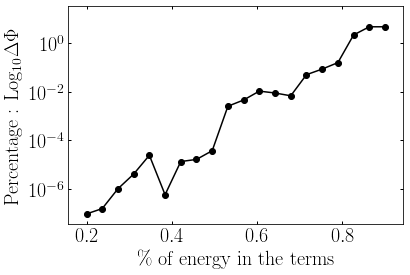

In [479]:
fig, ax  = plt.subplots()
plt.errorbar(e_cuts, np.abs(pot_mean_all), yerr=(pot_disp_all), c='k')
plt.scatter(e_cuts, np.abs(pot_mean_all), c='k')

ylabel(r'Percentage : $\rm{Log_{10}} \Delta \Phi$ ')
ax.set_yscale('log')
labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[1] = '$80 \%$'
#labels[2] = '$60 \%$'
#labels[3] = '$80 \%$'
#labels[4] = '$80 \%$'
xlabel('$\%$ of energy in the terms')
#savefig('pot_convergence.pdf', bbox_inches='tight')

In [190]:
N_particules = np.random.randint(0, len(pos_mwlmc5_b1_1e8[0]), 10000)

In [191]:
pot_mwlmc_biff = biff.potential(np.double(pos_mwlmc5_b1_1e8[N_particules]), S_matrix_mw_1e8, T_matrix_mw_1e8, G=G_gadget, M=1, r_s=r_s_sims)

In [192]:
a_mwlmc_biff = biff.gradient(np.double(pos_mwlmc5_b1_1e8[N_particules]), S_matrix_mw_1e8, T_matrix_mw_1e8, G=G_gadget, M=1, r_s=r_s_sims)

In [184]:
pot_mwlmc_biff_sim = biff.potential(np.ascontiguousarray(np.double(pos_pot_eval)), S_matrix_mw_1e8, T_matrix_mw_1e8, G=G_gadget, M=1, r_s=r_s_sims)

In [194]:
a_mwlmc_biff_sim = biff.gradient(np.ascontiguousarray(np.double(pos_pot_eval)), S_matrix_mw_1e8, T_matrix_mw_1e8, G=G_gadget, M=1, r_s=r_s_sims)

In [181]:
r_pot = np.logspace(0, 2.5, 100)

In [182]:
pos_pot_eval= np.array([r_pot, np.zeros(100), np.zeros(100)]).T

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


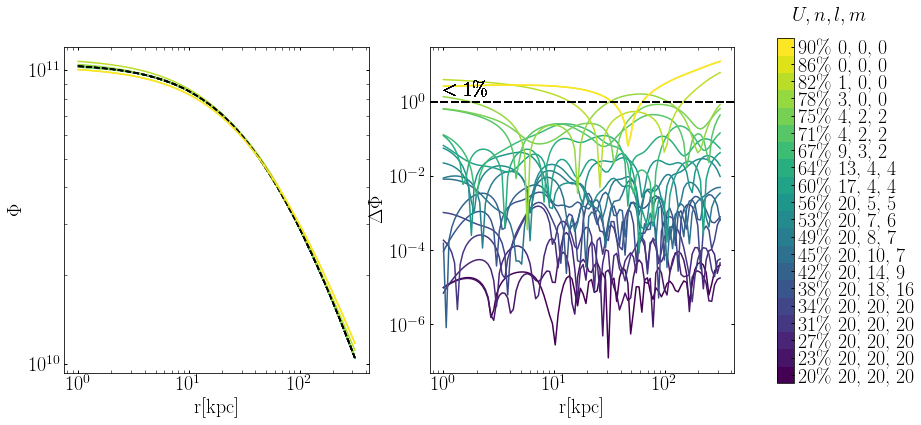

In [209]:
c1 = np.arange(0., 20)
cmap1 = plt.get_cmap("viridis", len(c1))
norm1 = matplotlib.colors.BoundaryNorm(np.arange(len(c1)+1),len(c1))
sm1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap1)
sm1.set_array([])


coeff_order = np.zeros((len(e_cuts),3))
j=0
fig = figure(figsize=(12, 6))

for i in e_cuts:
        S, T, coeff_order[j] = coefficients_energy_level(S_matrix_mw_1e8, T_matrix_mw_1e8, i)
        pot_e = biff.potential(np.ascontiguousarray(np.double(pos_pot_eval)), S, T, G=G_gadget, M=1, r_s=r_s_sims)
        subplot(1, 2, 1)
        loglog(r_pot, np.abs(pot_mwlmc_biff_sim), c='k', ls='--')
        loglog(r_pot, np.abs(pot_e), c=cmap1(j))
        xlabel('r[kpc]')
        ylabel(r'$\Phi$')

        subplot(1, 2, 2)
        loglog(r_pot, (np.abs(100*(pot_mwlmc_biff_sim-pot_e)/pot_mwlmc_biff_sim)), c=cmap1(j))
        text(1, 1.5, '$<1\%$')
        axhline(1, ls='--', c='k', lw=2)
        xlabel('r[kpc]')
        ylabel(r'$\Delta \Phi$')


        j+=1

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm1, cax=cb_ax)

list_coeff_1 = []

for i in range(20):
    list_coeff_1.append(str(int(e_cuts[i]*100)) + '\% ' +str(int(coeff_order[i][0])) + ', ' + str(int(coeff_order[i][1])) + ', ' + str(int(coeff_order[i][2])))

text(0.93, 1.05, '$U, n, l, m$')
#set the colorbar ticks and tick labels
cbar.set_ticks(0.5 + np.arange(0, 21, 1))
cbar.set_ticklabels(list_coeff_1)

savefig('pot_convergence.pdf', bbox_inches='tight')

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


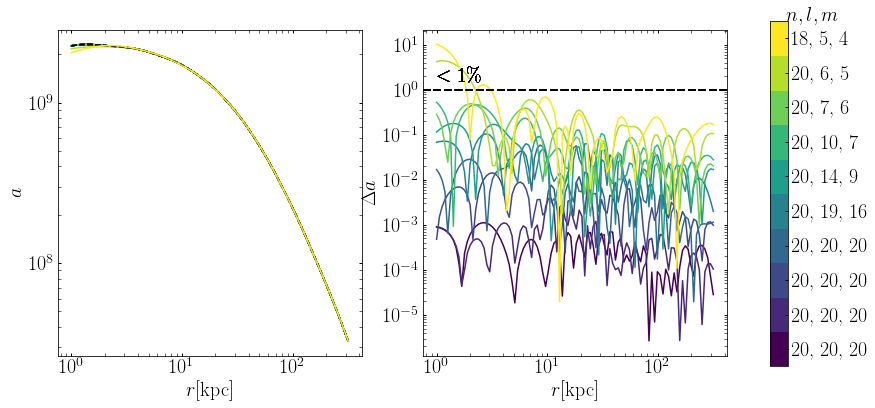

In [212]:
e_cuts2 = np.linspace(0.2, 0.6, 10)

c1 = np.arange(0., 10 )
cmap1 = plt.get_cmap("viridis", len(c1))
norm1 = matplotlib.colors.BoundaryNorm(np.arange(len(c1)+1),len(c1))
sm1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap1)
sm1.set_array([])


coeff_order = np.zeros((len(e_cuts2),3))
j=0
fig = figure(figsize=(12, 6))
a_vec = (a_mwlmc_biff_sim[:,0]**2 + a_mwlmc_biff_sim[:,1]**2 +  a_mwlmc_biff_sim[:,2]**2)**0.5

for i in e_cuts2:
        S, T, coeff_order[j] = coefficients_energy_level(S_matrix_mw_1e8, T_matrix_mw_1e8, i)
        grad_e = biff.gradient(np.ascontiguousarray(np.double(pos_pot_eval)), S, T, 
                               G=G_gadget, M=1, r_s=r_s_sims)

        subplot(1, 2, 1)
        a_sim = (grad_e[:,0]**2 + grad_e[:,1]**2 + grad_e[:,2]**2)**0.5

        loglog(r_pot, np.abs(a_vec), c='k', ls='--')
        loglog(r_pot, np.abs(a_sim), c=cmap1(j))
        ylabel(r'$a$')
        xlabel(r'$r$[kpc]')

        
        subplot(1, 2, 2)
        loglog(r_pot, 100*(np.abs((a_sim-a_vec)/a_sim)), c=cmap1(j))
        ylabel(r'$\Delta \vec{a}$')
        text(1, 1.5, '$<1\%$')

        axhline(1, c='k', ls='--', lw=2)

        ylabel(r'$\Delta a$')
        xlabel(r'$r$[kpc]')
        
        
        j+=1
        
        
cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm1, cax=cb_ax)

list_coeff_1 = []

for i in range(10):
    list_coeff_1.append(str(int(coeff_order[i][0])) + ', ' + str(int(coeff_order[i][1])) + ', ' + str(int(coeff_order[i][2])))

text(0.93, 1, '$n, l, m$')
#set the colorbar ticks and tick labels
cbar.set_ticks(0.5 + np.arange(0, 12, 1))
cbar.set_ticklabels(list_coeff_1)

savefig('a_convergence.pdf', bbox_inches='tight')

In [99]:
r_mwlmc = (MW_post[0][N_particules,0]**2 + MW_post[0][N_particules,1]**2 + MW_post[0][N_particules,2]**2)**0.5

In [107]:
N_particules2 = np.random.randint(0, 10**6, 10000)

In [108]:
r_halo = (pos_dm_halo[N_particules2,0]**2 + pos_dm_halo[N_particules2,1]**2 + pos_dm_halo[N_particules2,2]**2)**0.5

In [112]:
MW_post[2]

array([-126377.9140625, -122277.7421875, -126060.046875 , ...,
        -78058.8359375,  -78207.671875 ,  -78464.6328125], dtype=float32)

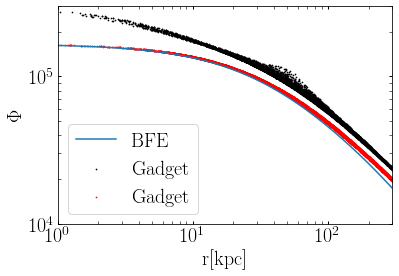

In [115]:
ax = subplot(1, 1, 1)
ax.scatter((r_mwlmc), (np.abs(MW_post[2][N_particules])), c='k', s=0.5, label='Gadget')
ax.plot((r_pot), (np.abs(pot_mwlmc_biff_sim*MW_mass[0])), label='BFE')


ax.scatter((r_halo), (np.abs(pot_dm_halo[N_particules2]*100)), c='r', s=0.5, label='Gadget')
#ax.plot((r_pot), (np.abs(pot_mwlmc_biff_sim*MW_mass[0])), label='BFE')


ax.legend()
ax.set_ylabel(r'$\Phi$')
ax.set_xlabel('r[kpc]')
ax.set_yscale('log')
ax.set_xscale('log')

xlim(1, 300)
ylim(1E4, 3E5)

savefig('gadget_bfe.png', bbox_inches='tight')